## Point collocation

Point collection method is a broad term, as it covers multiple variation, but
in a nutshell all consist of the following steps:

1. Generate samples $Q_1, \dots, Q_N$ that corresponds to your uncertain
   parameters.
2. Evaluate model solver $U_1=u(Q_1), \dots, U_N=u(Q_N)$ for each sample.
3. Select a polynomial expansion $\Phi_1, \dots, \Phi_M$.
4. Solve linear regression problem: $U_n = \sum_m c_m(t) \Phi_m(\alpha_n,
   \beta_n)$
   with respect for $c_1, \dots, c_M$.
5. Construct model approximation $u(q) = \sum_m c_m(t) \Phi_n(q)$
6. Perform model analysis on approximation $u(q)$ as a proxy for the real
   model.

Let us go through the steps in more detail.

### Generating samples

Unlike both [Monte Carlo integration](./monte_carlo_integration.ipynb) and
[pseudo-spectral projection](./pseudo_spectral_projection.ipynb), point
collocation method does not assume that the samples follows any particular
form. Though traditionally they are selected to be random, quasi-random,
nodes from quadrature integration, or a subset of the three.
For this case, we select the sample to follow the Sobol samples from [Monte
Carlo integration](./monte_carlo_integration.ipynb), and optimal quadrature
nodes from [pseudo-spectral projection](./pseudo_spectral_projection.ipynb):

In [35]:
from ipynb.fs.full.pseudo_spectral_projection import gauss_quads

gauss_nodes = [nodes for nodes, _ in gauss_quads]

The number of Sobol samples to use at each order is arbitrary, but for
compare, we select them to be the same as the Gauss nodes:

In [36]:
from ipynb.fs.full.monte_carlo_integration import sobol_samples

sobol_nodes = [sobol_samples[:, :nodes.shape[1]] for nodes in gauss_nodes]

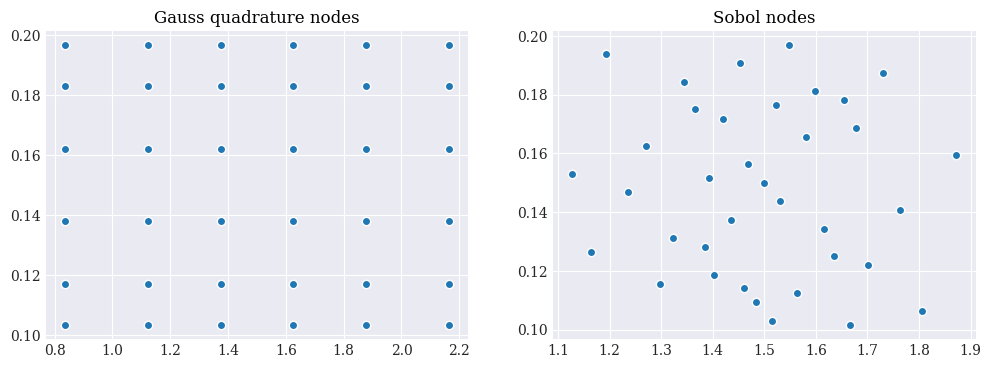

In [37]:
from matplotlib import pyplot

pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(121)
pyplot.scatter(*gauss_nodes[4])
pyplot.title("Gauss quadrature nodes")

pyplot.subplot(122)
pyplot.scatter(*sobol_nodes[4])
pyplot.title("Sobol nodes")

pyplot.show()

### Evaluating model solver

Like in the case of [problem formulation](./problem_formulation.ipynb) again,
evaluation is straight forward:

In [38]:
import numpy
from ipynb.fs.full.problem_formulation import model_solver

gauss_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes in gauss_nodes
]

In [39]:
sobol_evals = [
    numpy.array([model_solver(node) for node in nodes.T])
    for nodes in sobol_nodes
]

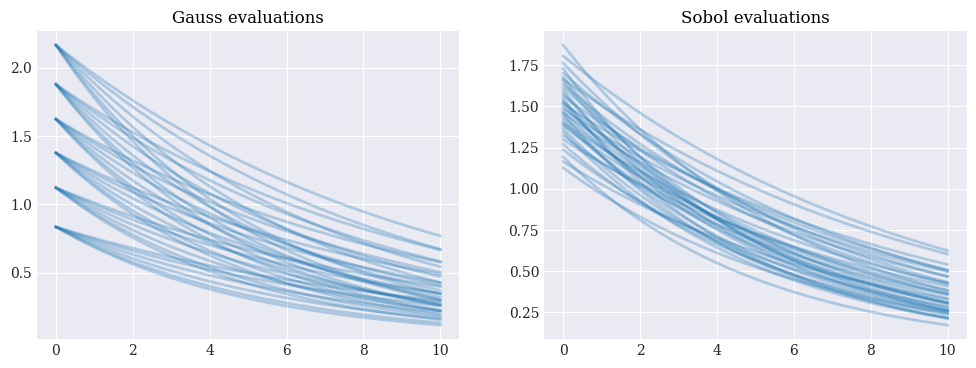

In [40]:
from ipynb.fs.full.problem_formulation import coordinates

pyplot.subplot(121)
pyplot.plot(coordinates, gauss_evals[4].T, alpha=0.3)
pyplot.title("Gauss evaluations")

pyplot.subplot(122)
pyplot.plot(coordinates, sobol_evals[4].T, alpha=0.3)
pyplot.title("Sobol evaluations")

pyplot.show()

### Select polynomial expansion

Unlike [pseudo spectral
projection](./pseudo_spectral_projection.ipynb), the polynomial in
point collocations are not required to be orthogonal. But stability
wise, orthogonal polynomials have still been shown to work well.
This can be achieved by using the
[chaospy.generate_expansion()](../reference/api/chaospy.generate_expansion.rst)
function:

In [41]:
import chaospy
from ipynb.fs.full.problem_formulation import joint

expansions = [chaospy.generate_expansion(order, joint)
              for order in range(1, 10)]
expansions[0].round(10)

polynomial([1.0, q1-0.15, q0-1.5])

### Solve the linear regression problem

With all samples $Q_1, ..., Q_N$, model evaluations $U_1, ..., U_N$ and
polynomial expansion $\Phi_1, ..., \Phi_M$, we can put everything together to
solve the equations:

$$
    U_n = \sum_{m=1}^M c_m(t) \Phi_m(Q_n) \qquad n = 1, ..., N
$$

with respect to the coefficients $c_1, ..., c_M$.

This can be done using the helper function
[chaospy.fit_regression()](../reference/api/chaospy.fit_regression.rst):

In [42]:
gauss_model_approx = [
    chaospy.fit_regression(expansion, samples, evals)
    for expansion, samples, evals in zip(expansions, gauss_nodes, gauss_evals)
]

In [43]:
sobol_model_approx = [
    chaospy.fit_regression(expansion, samples, evals)
    for expansion, samples, evals in zip(expansions, sobol_nodes, sobol_evals)
]

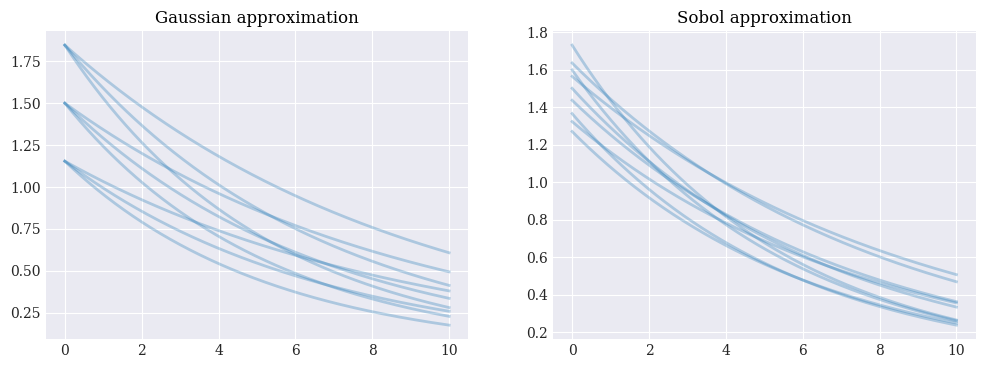

In [44]:
pyplot.subplot(121)
model_approx = gauss_model_approx[4]
evals = model_approx(*gauss_nodes[1])
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Gaussian approximation")

pyplot.subplot(122)
model_approx = sobol_model_approx[1]
evals = model_approx(*sobol_nodes[1])
pyplot.plot(coordinates, evals, alpha=0.3)
pyplot.title("Sobol approximation")

pyplot.show()

### Descriptive statistics

The expected value and variance is calculated as follows:

In [45]:
expected = chaospy.E(gauss_model_approx[-2], joint)
std = chaospy.Std(gauss_model_approx[-2], joint)

expected[:4].round(4), std[:4].round(4)

(array([1.5   , 1.4977, 1.4955, 1.4933]),
 array([0.2   , 0.1997, 0.1994, 0.1991]))

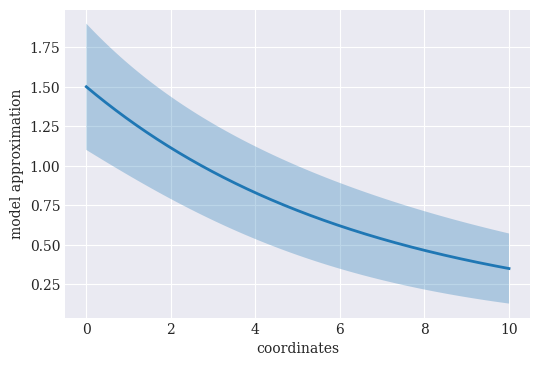

In [46]:
pyplot.rc("figure", figsize=[6, 4])

pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
pyplot.fill_between(
    coordinates, expected-2*std, expected+2*std, alpha=0.3)
pyplot.plot(coordinates, expected)

pyplot.show()

### Error analysis

It is hard to assess how well these models are doing from the final
estimation alone. They look about the same. So to compare results, we do
error analysis. To do so, we use the reference analytical solution and error
function as defined in  [problem formulation](./problem_formulation.ipynb).

In [47]:
from ipynb.fs.full.problem_formulation import error_in_mean, error_in_variance

error_in_mean(expected), error_in_variance(std**2)

(2.7883251263460805e-15, 3.4891142128290477e-12)

The analysis can be performed as follows:

In [48]:
sizes = [nodes.shape[1] for nodes in gauss_nodes]

In [49]:
eps_gauss_mean = [
    error_in_mean(chaospy.E(model, joint))
    for model in gauss_model_approx
]
eps_gauss_var = [
    error_in_variance(chaospy.Var(model, joint))
    for model in gauss_model_approx
]

In [50]:
eps_sobol_mean = [
    error_in_mean(chaospy.E(model, joint))
    for model in sobol_model_approx
]
eps_sobol_var = [
    error_in_variance(chaospy.Var(model, joint))
    for model in sobol_model_approx
]

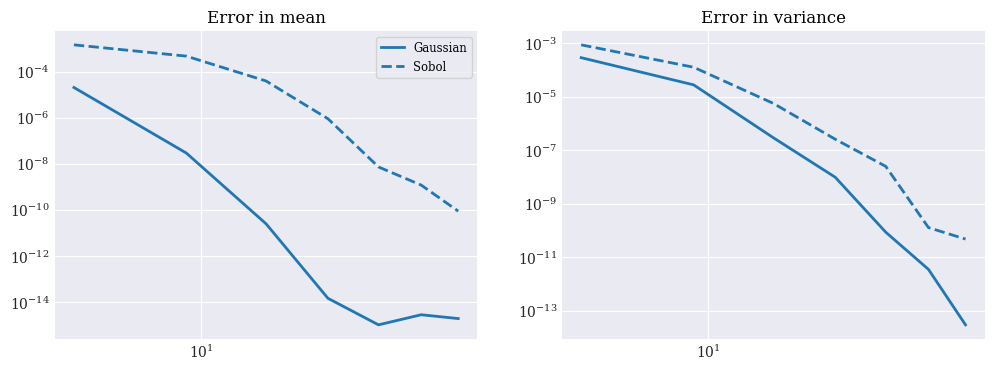

In [51]:
pyplot.rc("figure", figsize=[12, 4])

pyplot.subplot(121)
pyplot.title("Error in mean")
pyplot.loglog(sizes, eps_gauss_mean, "-", label="Gaussian")
pyplot.loglog(sizes, eps_sobol_mean, "--", label="Sobol")
pyplot.legend()

pyplot.subplot(122)
pyplot.title("Error in variance")
pyplot.loglog(sizes, eps_gauss_var, "-", label="Gaussian")
pyplot.loglog(sizes, eps_sobol_var, "--", label="Sobol")

pyplot.show()